In [211]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from math import ceil, sqrt

In [212]:
def read(i, type):
    df = pd.read_csv('dataset/' + str(i).rjust(2, '0') + '_' + type + '.csv')
    y = df['y']
    x = df.drop('y', axis=1)
    return x, y

dfs = []
for i in range(1, 21 + 1):
    dfs.append({'data': [read(i, 'train'),
                         read(i, 'test')]})

Для каждого набора данных определите оптимальную высоту дерева принятия решений относительно точности классификации на проверочном множестве.

In [213]:
%%time
for df in dfs:
    train, test = df['data']
    x_train, y_train = train
    x_test, y_test = test

    for params in ParameterGrid({'criterion': ['gini', 'entropy']
                                ,'splitter' : ['best', 'random']
                                ,'max_depth': [5, 10, 15]}):
        clf = DecisionTreeClassifier(**params)
        clf.fit(x_train, y_train)

        accuracy = accuracy_score(y_test, clf.predict(x_test))
        if 'max score' not in df or accuracy > df['max score']:
            df['max score'] = accuracy
            df['max depth'] = params['max_depth']

Wall time: 23.8 s


Выберите два набора данных: набор с минимальной и максимальной  оптимальной высотой.
Для этих двух наборов данных нарисуйте график зависимости точности классификации на тренировочном и проверочном множестве от высоты.

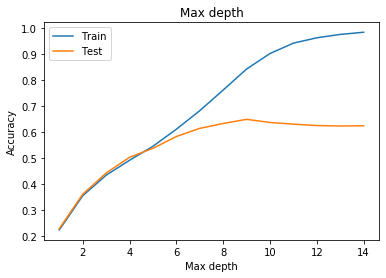

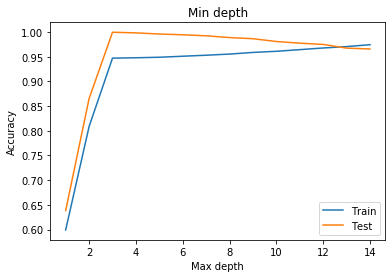

In [214]:
get = lambda x: x['max depth']
outliers = max(dfs, key=get), min(dfs, key=get)

for df, title in zip(outliers, ['Max depth', 'Min depth']):
    train, test = df['data']
    x_train, y_train = train
    x_test, y_test = test

    plt.xlabel("Max depth")
    plt.ylabel("Accuracy")

    for x_test, y_test, label in zip([x_train, x_test], [y_train, y_test], ['Train', 'Test']):
        records = {}
        for max_depth in range(1, 15):
            clf = DecisionTreeClassifier(max_depth=max_depth).fit(x_train, y_train)
            records[max_depth] = accuracy_score(y_test, clf.predict(x_test))
        plt.plot(list(records.keys()), list(records.values()), label=label)
    plt.legend()
    plt.title(title)
    plt.show()

Для каждого набора данных постройте лес решающих деревьев без ограничения высоты и определите точность классификации на тренировочном и проверочном множестве.

In [215]:
class RandomForest(BaseEstimator):
    def __init__(self, n=1, max_features='auto'):
        self.n = n
        self.trees = [DecisionTreeClassifier(max_features=max_features) for _ in range(n)]
        

    def fit(self, x_train, y_train):
        train = pd.concat([x_train, y_train], axis=1)
        for t in self.trees:
            sample = train.sample(frac=1, replace=True)
            t.fit(sample.drop('y', axis=1), sample['y'])
        return self

    
    def predict_one(self, x):
        predictions = [t.predict([x])[0] for t in self.trees]
        return max(set(predictions), key=predictions.count)

    
    def predict(self, x_test):
        return [self.predict_one(x) for x in x_test.to_numpy()]

In [217]:
%%time
print('n'.ljust(10, ' ') + 'train score'.ljust(20, ' ') + 'test score'.ljust(20, ' '))

for df in dfs:
    train, test = df['data']
    x_train, y_train = train
    x_test, y_test = test

    for params in ParameterGrid({'n': [1, 5, 10, 20, 40]}):
        clf = RandomForest(**params)
        clf.fit(x_train, y_train)
        
        accuracy = accuracy_score(y_train, clf.predict(x_train)), accuracy_score(y_test, clf.predict(x_test))
        n = params['n']

        print(str(n).ljust(6, ' ') + str(accuracy[0]).ljust(20, ' ') + str(accuracy[1]).ljust(20, ' '))
    print()

n         train score         test score          
1     0.941917244924184   0.8771524029812388  
5     0.9879208429709586  0.9907478797224364  
10    0.9894628630172192  0.9964019532253919  
20    0.995887946543305   0.9987149832947828  
40    0.9982009766126959  0.9992289899768697  

1     0.7290076335877863  0.25165394402035624 
5     0.9493638676844783  0.3178117048346056  
10    0.9956743002544529  0.39720101781170486 
20    0.9997455470737914  0.4435114503816794  
40    1.0                 0.5111959287531807  

1     0.9469623915139826  0.9247830279652844  
5     0.9860173577627772  0.9797492767598843  
10    0.9966248794599807  0.9966248794599807  
20    0.9971070395371263  0.9995178399228544  
40    0.9995178399228544  1.0                 

1     0.8949565217391304  0.7492173913043478  
5     0.9822608695652174  0.8187826086956522  
10    0.9975652173913043  0.8695652173913043  
20    0.9993043478260869  0.920695652173913   
40    1.0                 0.9074782608695652  

1    